# Airbnb data analysis

#### Business Understanding
The purpose of this project is to analyze the Airbnb Seattle dataset
What should a guest on a tight budget consider when trying to book the next Airbnb accommodation for a night?
And as an Airbnb host, which area is considered a popular one when renting out your place?

This notebook seeks to investigate the following business questions:
1) How do the prices differ from area to area in Airbnb listings?
2) Is there a cheapest time to go travel?
3) What is the most important contributor to a listing price?

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import calendar

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from scripts.data_analysis import prepare_data

#### Data Understanding
Read the 2 dataset, then convert the price columns to pure numerical values by removing the $ sign, $.00$ digits and unwanted commas for Airbnb prices that are more than >$999 $.
Merge the listing neightbourhood (df) to the calendar time series data (df_cal).

In [3]:
df = pd.read_csv(os.path.abspath("./data/listings.csv"))
df_cal = pd.read_csv(
    os.path.abspath("./data/calendar.csv"),
    dtype={
        'price': str,
        'date': str
    }
)
# remove $, , and .00 from the Price column.
df_cal['price'] = df_cal.price.astype(str).apply(lambda s: s.replace('$', '').replace('.00', '').replace(',', ''))
df['price'] = df.price.astype(str).apply(lambda s: s.replace('$', '').replace('.00', '').replace(',', '')).astype(int)

In [4]:
# merge neighbourhood to the calendar data.
df_area = pd.merge(
    df_cal,
    df[[
        'id',
        'neighbourhood_group_cleansed',
    ]],
    how='left',
    left_on='listing_id',
    right_on='id'
)

In [21]:
print(df.shape, df_cal.shape)
df.describe()

(3818, 92) (1048575, 4)


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354321,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


### Data preparation
How popular is each neighbourhood? Calculate the occupancy rate (fraction of dates occupied) for each neighbourhood.
Plot both the occupancy, price boxplot distributions and # of Airbnbs in the neighbourhoods.

In [5]:
frac_bookings = {
    "Area": [],
    "Percentage of booked nights": [],
    "Price": [],
    "Mean_price": [],
    "Number of Airbnbs": [],
    }
areas, counts = np.unique(df_area.neighbourhood_group_cleansed, return_counts=True)
for area, count in zip(areas, counts):
    taken = df_area.loc[
        (df_area.neighbourhood_group_cleansed==area) &
        (df_area.available == 'f')
    ].shape[0]/count

    area_price = df.loc[df.neighbourhood_group_cleansed==area].price
    
    frac_bookings['Area'].append(area)
    frac_bookings['Percentage of booked nights'].append(taken) # percentage of how many days the listings are taken.
    frac_bookings['Price'].append(area_price)
    frac_bookings['Mean_price'].append(area_price.mean())
    frac_bookings['Number of Airbnbs'].append(int(count/365))
frac_df = pd.DataFrame(frac_bookings)
frac_df = frac_df.sort_values(by='Percentage of booked nights', ascending=False)

<AxesSubplot:xlabel='Percentage of booked nights', ylabel='Area'>

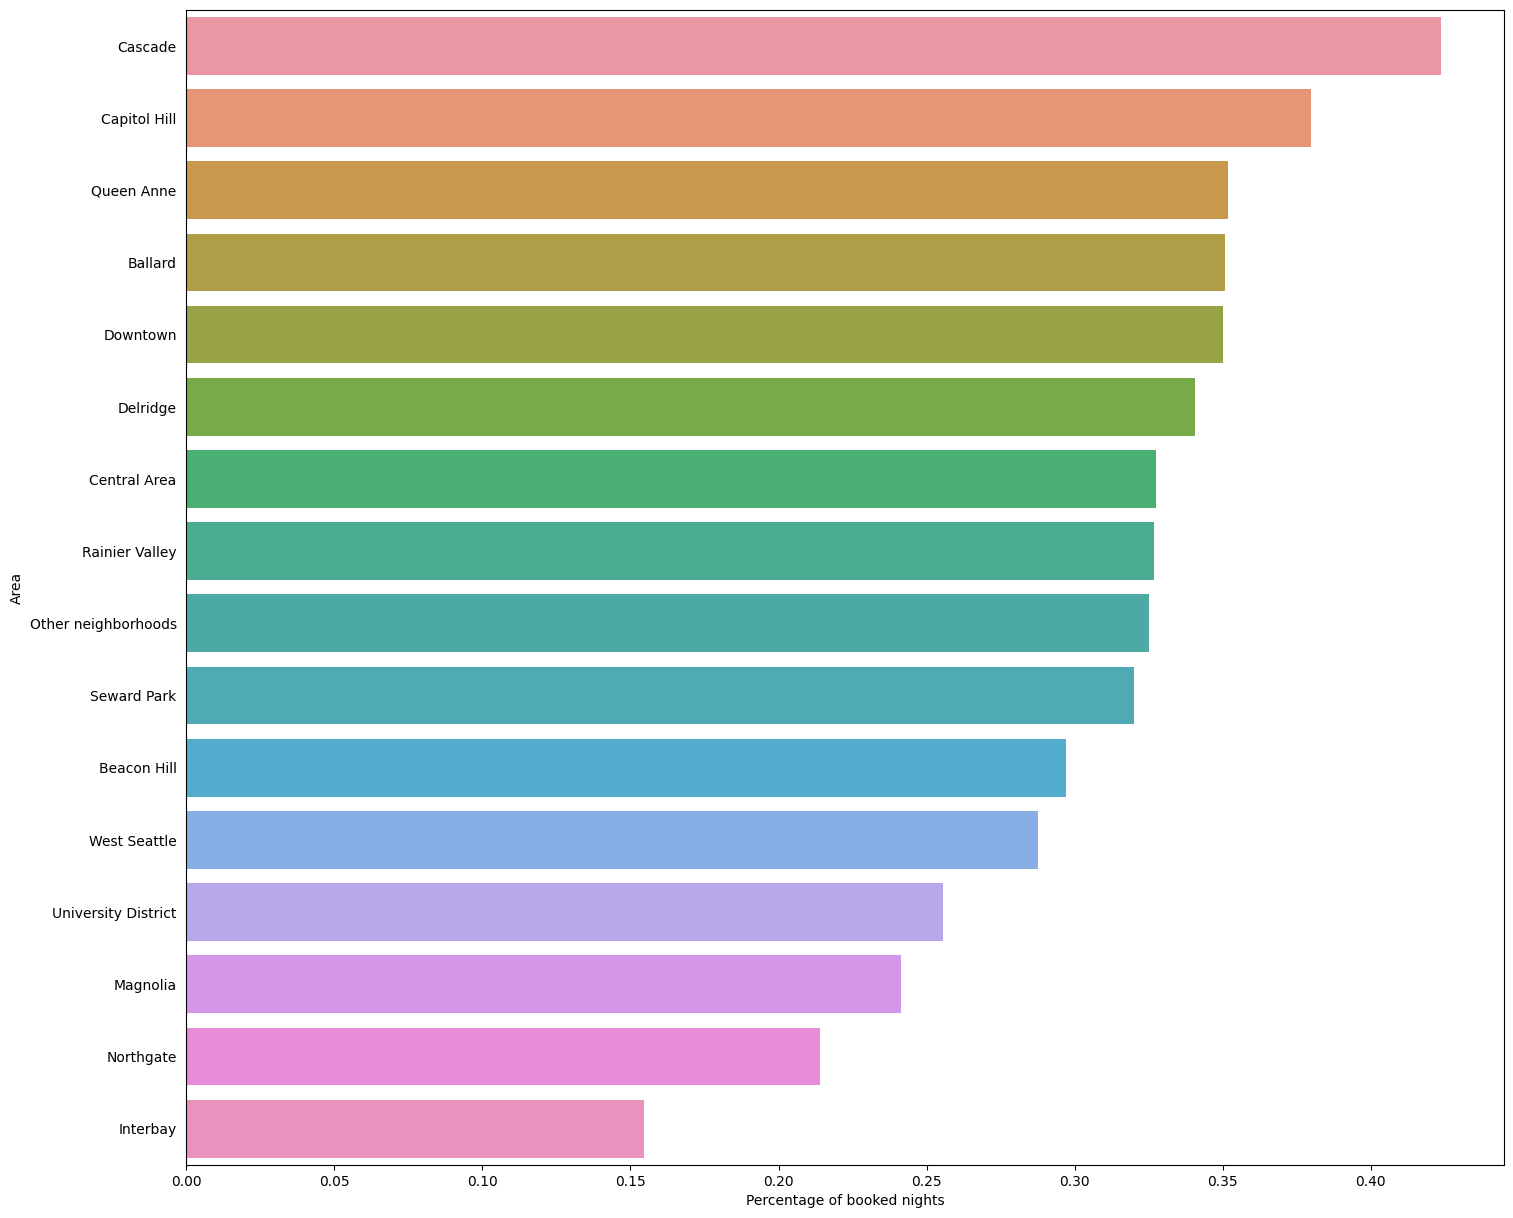

In [6]:
x = frac_df['Percentage of booked nights']
y = frac_df['Area']
fig, ax = plt.subplots(figsize=(17,15))
ax = sns.barplot(x=x, y=y, orient='h', ax=ax)
ax.set(yticklabels=[])
ax.tick_params(left=False)
ax.bar_label
sns.barplot(data=frac_df, x="Percentage of booked nights", y="Area")

<AxesSubplot:xlabel='Price', ylabel='Area'>

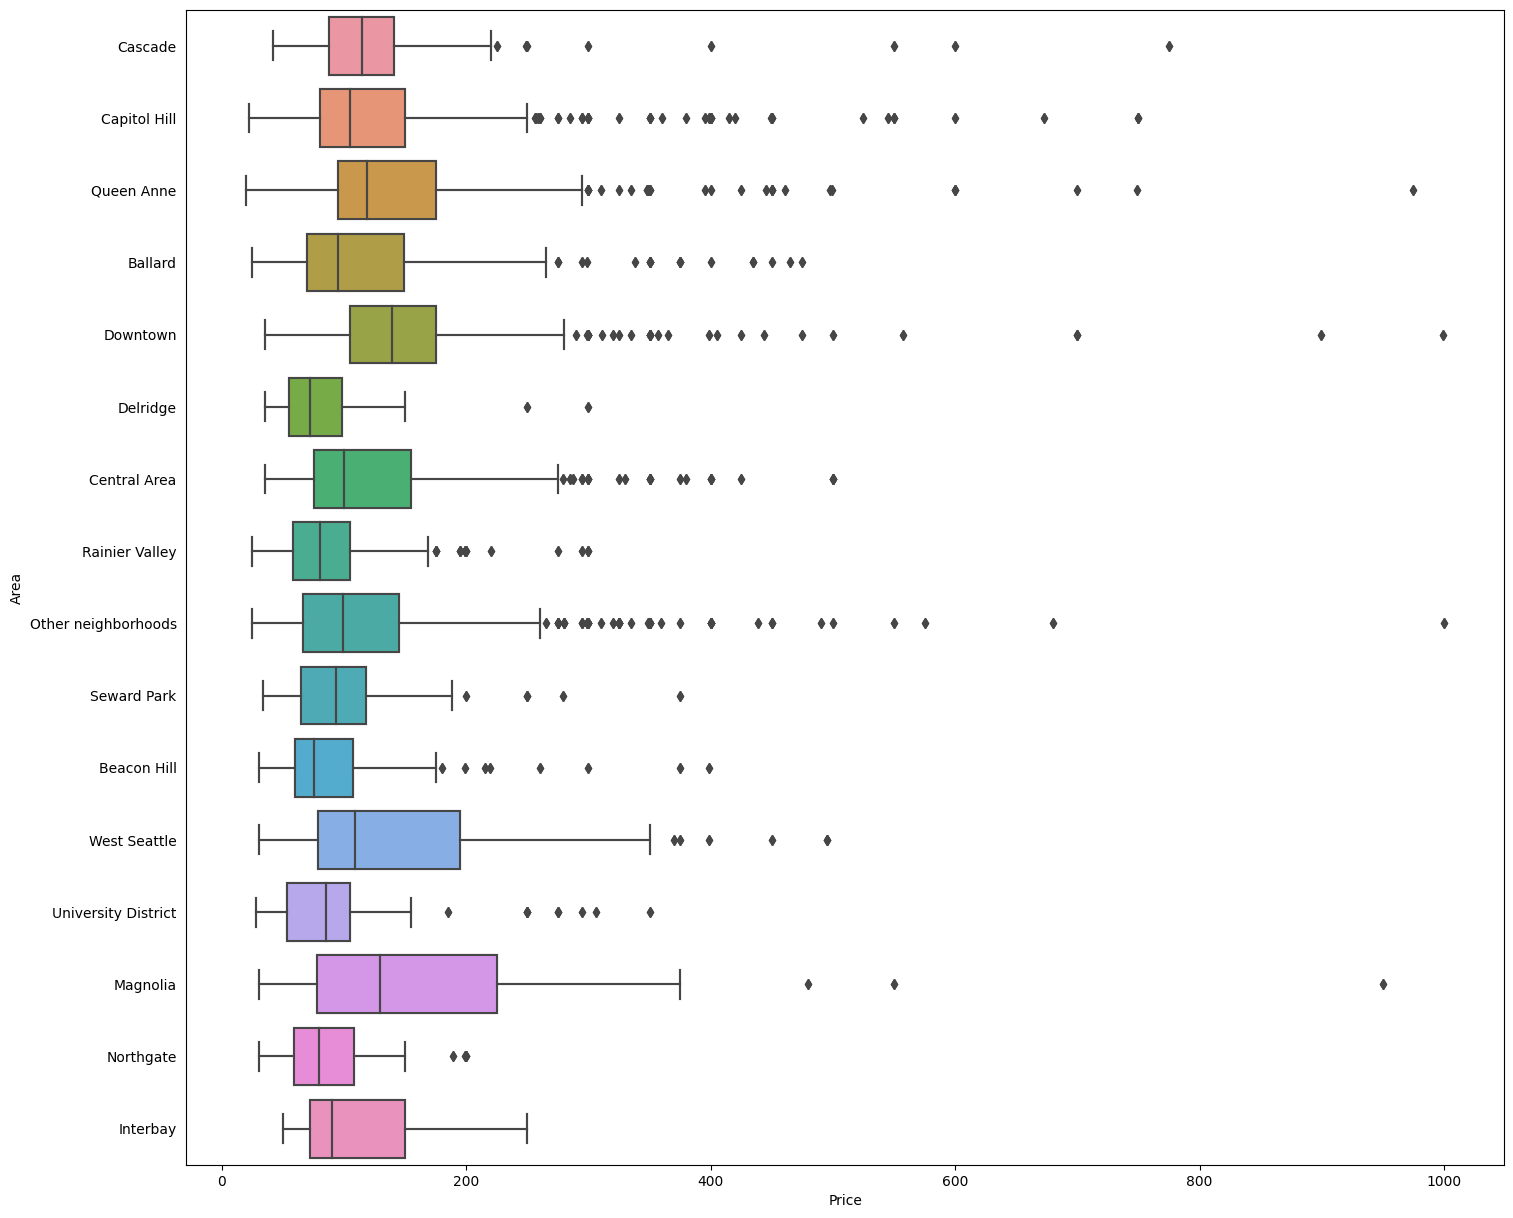

In [7]:
# neighbourhood price distribution.
df_price = frac_df.explode('Price')
x = df_price['Price']
y = df_price['Area']
fig, ax = plt.subplots(figsize=(17,15))
ax = sns.boxplot(x=x, y=y, orient='h', ax=ax)
ax.set(yticklabels=[])
ax.tick_params(left=False)
ax.bar_label
sns.boxplot(data=df_price, x=x, y=y)

<AxesSubplot:xlabel='Number of Airbnbs', ylabel='Area'>

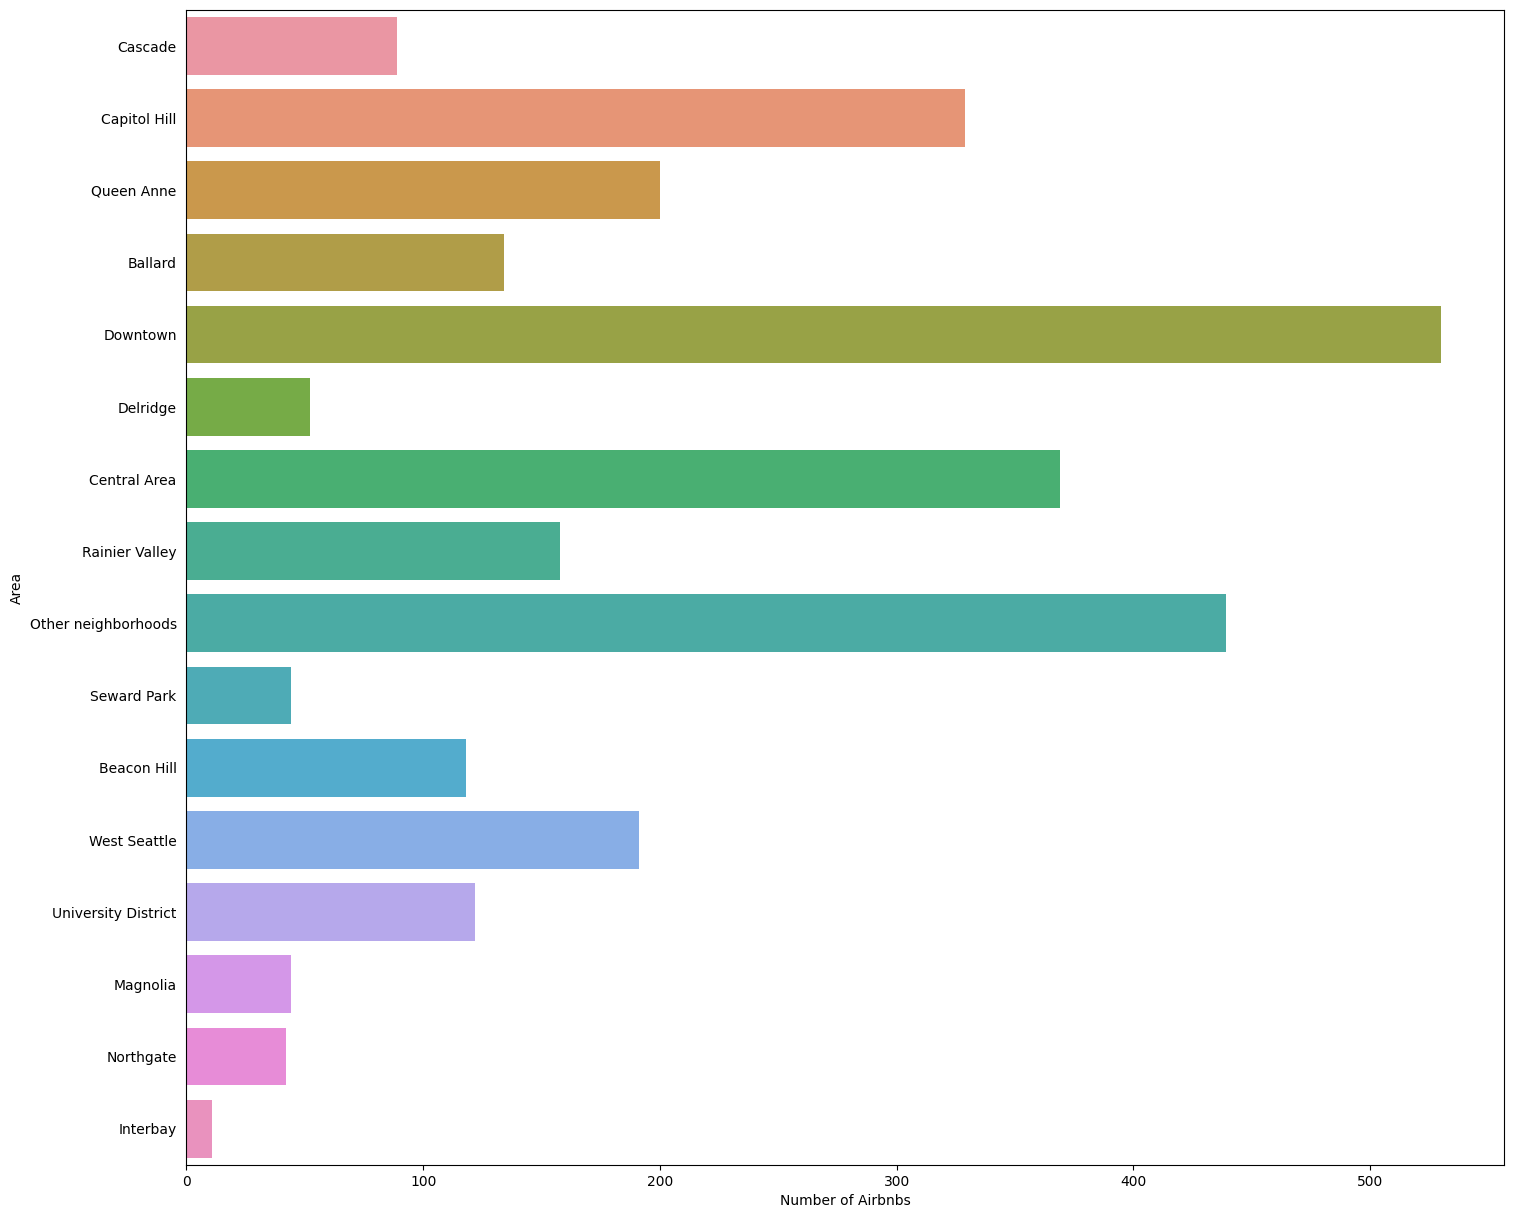

In [8]:
# how many Airbnb's in each neighbourhood?
x = frac_df['Number of Airbnbs']
y = frac_df['Area']
fig, ax = plt.subplots(figsize=(17,15))
ax = sns.barplot(x=x, y=y, orient='h', ax=ax)
ax.set(yticklabels=[])
ax.tick_params(left=False)
ax.bar_label
sns.barplot(data=frac_df, x="Number of Airbnbs", y="Area")

#### Data Modelling:
How well can we predict the Airbnb price? 
Let's investigate how the price correlates to other numerical values from the dataset.


<AxesSubplot:>

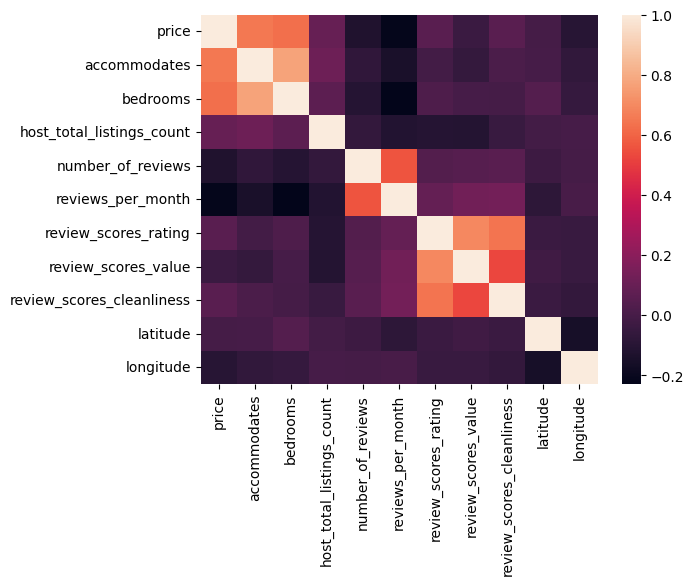

In [9]:
# prices correlations
corr = df[[
    'price',
    'accommodates',
    'bedrooms',
    'host_total_listings_count',
    'number_of_reviews',
    'reviews_per_month',
    'review_scores_rating',
    'review_scores_value',
    'review_scores_cleanliness',
    'latitude',
    'longitude'
]].corr()
sns.heatmap(corr)

Is there a cheapest time to go travel? This question is relevant to ask for a customer to is looking to visit Seattle while saving a dime.
Let's investigate how the prices changes dependent on weekdays and the calendar year.

In [10]:
df_available = df_area[(df_area.available=='t')].copy()
df_available['Weekday'] = df_available.date.apply(lambda s: calendar.day_name[datetime.datetime.strptime(s, '%m/%d/%Y').weekday()])
df_available['price'] = df_available.price.astype(int)
price_avg = []
dates = df_available.date.unique()
for date in dates:
    day_price = df_available[df_available.date==date].price.mean()
    price_avg.append(day_price)
cal_price = pd.DataFrame({'date': dates, 'price': price_avg})

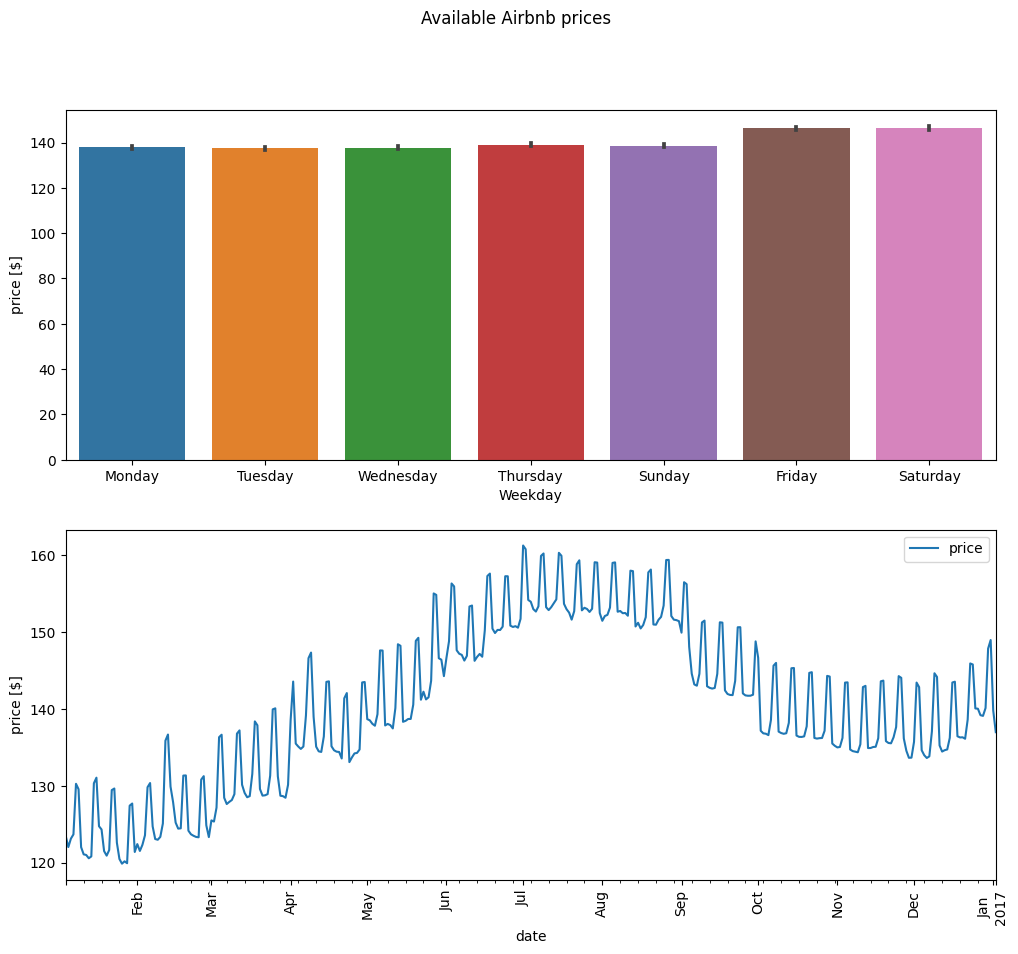

In [11]:
# plot prices timeline overview.
fig, axes = plt.subplots(2, figsize=(12, 10))
fig.suptitle('Available Airbnb prices')
sns.barplot(
    ax=axes[0],
    data=df_available,
    x='Weekday',
    y='price',
)
axes[0].set_ylabel('price [$]')
cal_price.date = pd.to_datetime(cal_price.date, format="%m/%d/%Y")
cal_price.sort_values(by='date', ascending=True).plot(ax=axes[1], x='date', y='price', rot=90)
axes[1].set_ylabel('price [$]')
plt.show()

Linear regression modelling:
- Choose a feature subset of numerical/categorical features.
- Clean data: For the numerical columns, remove NaNs. For the categorical columns keep NaN entries and include them
- Make a K=5 cross validated linear regression model
- Evaluate average correlation r2 scores for the predicted vs. true Airbnb price.
- Investigate average coefficient weights from the linear regression to assess feature importance.
NaN entries are removed using .dropna on the subset of numerical columns. This discards 647 rows and leaves a total of 3171 rows to model. The rows were removed instead of trying to impute values to avoid inducing model bias from missing data modelling. Note that future work could consider imputing values to save data, and then investigate how it affects the price predictions.

In [12]:
# load numerical columns.
vars = [
    'price',
    'host_total_listings_count',
    'accommodates',
    'number_of_reviews',
    'review_scores_rating',
    'reviews_per_month',
    'host_since'
]

# load categorical columns.
cat_cols = [
    'host_response_time',
    'host_is_superhost',
    'neighbourhood_group_cleansed',
    'room_type',
    'bed_type',
    'instant_bookable',
    'cancellation_policy',
    'require_guest_phone_verification'
]

df_prep = prepare_data(df, vars=vars, cat_cols=cat_cols)

In [13]:
# partition to features (X) and target (y)
y = df_prep.price
X = df_prep.loc[:, df_prep.columns != 'price']

In [14]:
# fit a linear model, K=5 cross validate.
seeds = [12834, 43271, 6555, 2359, 42]
r2_scores = []
importance = {'Coefficient': [], 'Column name': []}
for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=seed)
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)
    lm_pred = lm_model.predict(X_test)
    importance['Coefficient'].append(lm_model.coef_)
    importance['Column name'].append(X_train.columns)
    lm_r2 = r2_score(y_test, lm_pred)
    r2_scores.append(lm_r2)
importance = pd.DataFrame(importance).explode(['Coefficient', 'Column name']).sort_values(by='Coefficient', ascending=False)
mean_r2 = sum(r2_scores)/len(r2_scores)

During the 5 training rounds, the fitted model returns linear coefficients for each feature. Taking an average of the fitted feature coefficients gives a relative feature importance for each feature. If the coefficient ~0, then the model may not be relevant.

<AxesSubplot:xlabel='Column name'>

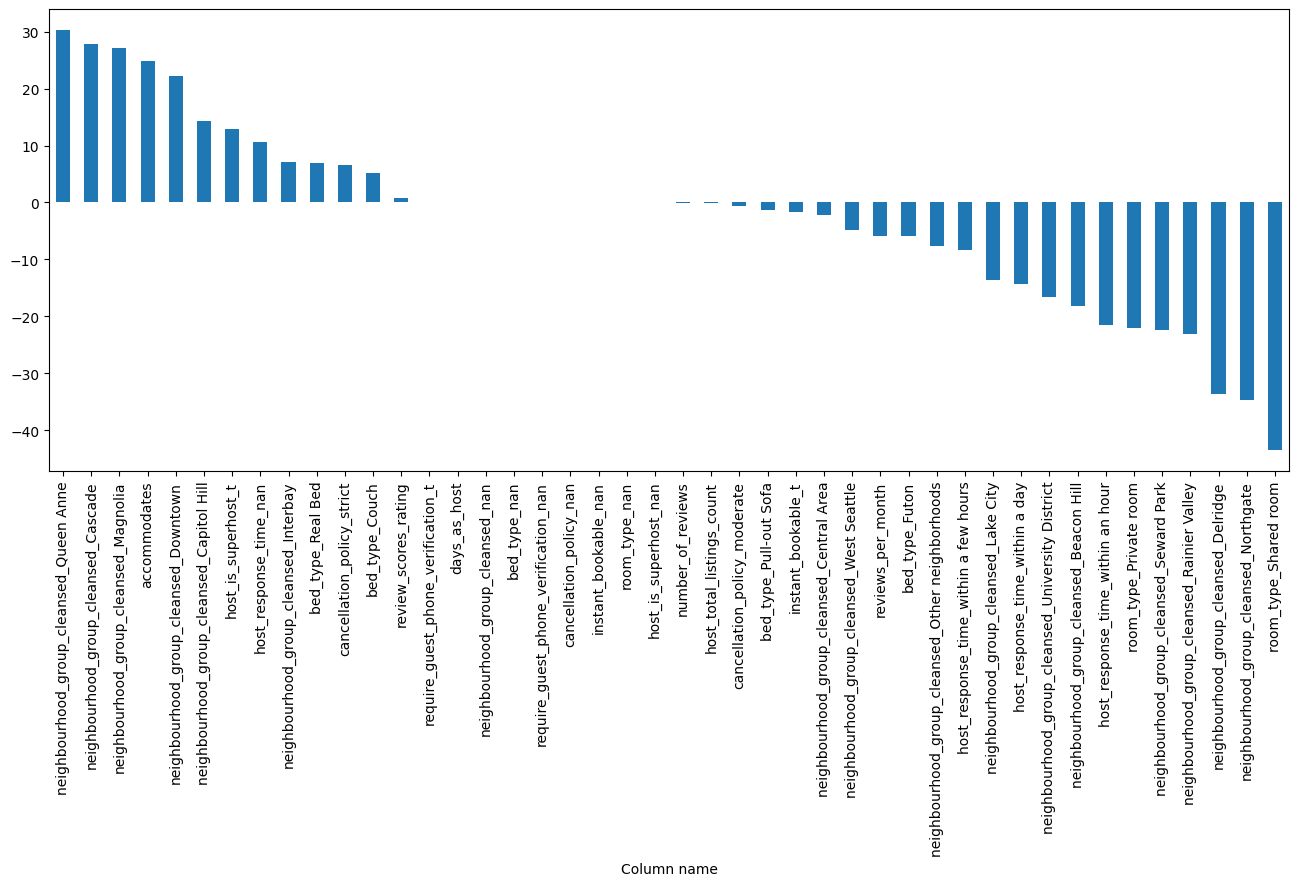

In [15]:
# plot the linear model coefficients.
fig = plt.figure(figsize=(16, 6))
importance_groups = importance.groupby('Column name')['Coefficient'].mean().sort_values(ascending=False)
importance_groups.plot(kind='bar', y='Coefficient')

Plot the predicted-true airbnb prices together with a fitted linear model. The average model performance is R^2=0.55.

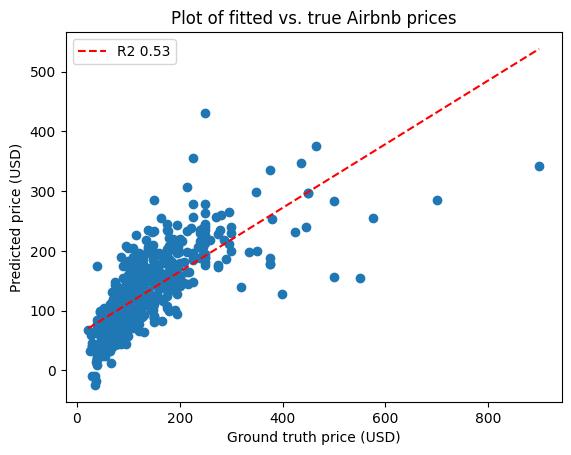

In [16]:
grid = np.linspace(min(y_test), max(y_test), len(y_test))
z = np.poly1d(np.polyfit(y_test, lm_pred, 1))
plt.plot(grid, z(grid), 'r--', label="R2 {:.2f}".format(mean_r2))
plt.scatter(y_test, lm_pred)
plt.title('Plot of fitted vs. true Airbnb prices')
plt.legend(loc="upper left")
plt.xlabel("Ground truth price (USD)")
plt.ylabel("Predicted price (USD)")
plt.show()